In [47]:
using Base.Iterators
using Random
using DataFrames
using PyPlot
using StatsBase
using SmoothingSplines
using Graphs

seed = 21;
resdir = "properties_test/stats/";
graphdir = "properties_test/graphs/";

Random.seed!(seed);

In [2]:
seed = 21;
resdir = "properties_test/stats/";
graphdir = "properties_test/graphs/";

In [3]:
Random.seed!(seed);

In [4]:
#Parameters:

n = 10^4
ξs = range(0.0, 1.0, step = 0.05)
βs = [1.1, 1.5, 1.9]
γs = [2.1, 2.5, 2.9]
min_degs = [5]
is_local = [true, false];

Additional functions/data preprocessing:

In [5]:
colnames = [:iter, :modularity, :global_coeff, :avg_local_coeff, Symbol("δ+1"),Symbol("δ+2"),Symbol("δ+3"),
            :giant_component_size, :giant_component_volume, Symbol("size_0.05"), Symbol("size_0.05_relative"),
            Symbol("size_0.1"), Symbol("size_0.1_relative"), Symbol("size_0.15"), Symbol("size_0.15_relative"),
            :internal_edges_mean, :internal_edges_std, :correlation_coeff, :corr_exp];
colnames2 = [:avg, :std, :Q1,:Q2,:Q3, :min, :max];
colnames3 = [:avg_part_coeff, :hubs, :provincial_hubs, :connector_hubs, :kinless_hubs, 
            :ultra_peripheral_nodes, :peripheral_nodes, :connector_nodes, :kinless_nodes];

In [6]:
function get_plot_data(algo, is_local, attr; 
        n = n, ξ = ξ, β = β, γ = γ, min_deg = min_deg,
        resdir = resdir, fname = "stats", colnames= colnames)
    dfname = resdir * "$(algo)_$(fname)_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(is_local).dat"
    df = DataFrame(Array(hcat([parse.(Float64, x) for x in split.(readlines(dfname),";")]...)'), colnames)
    df[!,attr]
end 

get_plot_data (generic function with 1 method)

In [7]:
degree_correlation(g) = [sum(sum(degree(g,nei) for nei in neighbors(g,n))/length(neighbors(g,n))
    for n in findall(x-> x == deg,degree(g)))/sum(degree(g).==deg)
        for deg in sort(unique(degree(g))) if deg != 0]

degree_correlation (generic function with 1 method)

In [8]:
function deg_corr_neutral(G, mode::Function)
    x = mode(G)
    return mean(x .^ 2)/mean(x)
end

deg_corr_neutral (generic function with 1 method)

### Modularity

In [9]:
#Parameters:

ξ = 0.7
β = 1.5
γ = 2.9
min_deg = 5

5

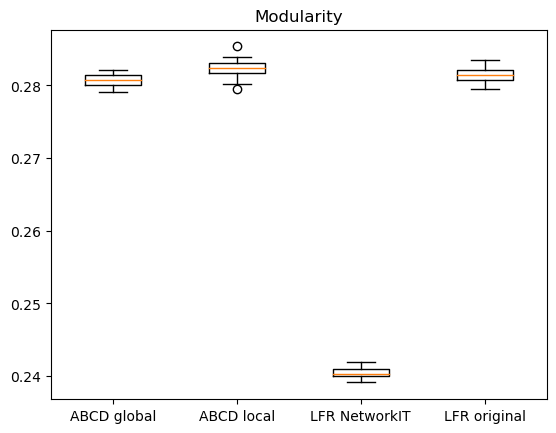

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\barto\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject Text(0.5, 1.0, 'Modularity')

In [10]:
attr = :modularity

data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
title("Modularity")

#saving to a file:
#savefig("fig1.eps")

### Global Clustering Coefficient

In [11]:
#Parameters:

ξ = 0.25
β = 1.5
γ = 2.9
min_deg = 5

5

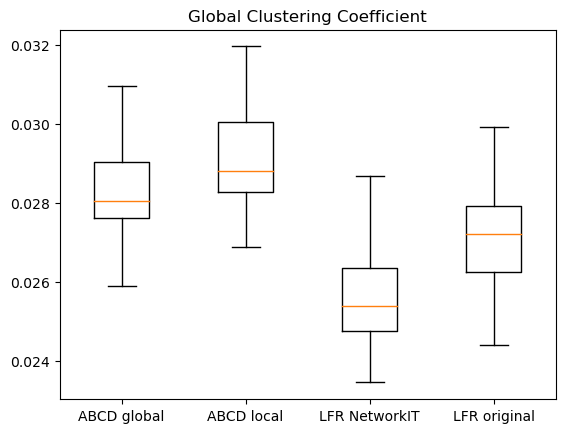

PyObject Text(0.5, 1.0, 'Global Clustering Coefficient')

In [12]:
attr = :global_coeff

data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
title("Global Clustering Coefficient")

#saving to a file:
#savefig("fig2.eps")

### Average Local Clustering Coefficient

In [13]:
#Parameters:

ξ = 0.25
β = 1.5
γ = 2.9
min_deg = 5

5

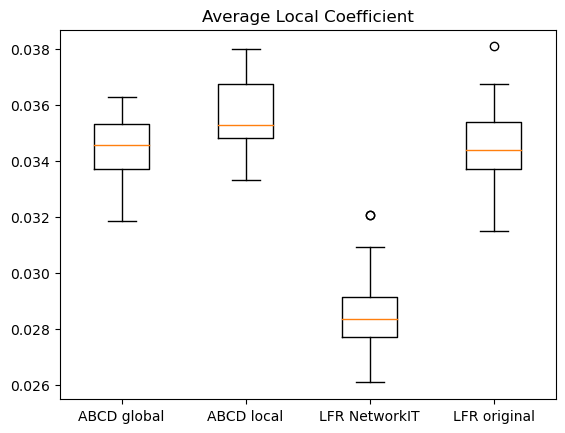

PyObject Text(0.5, 1.0, 'Average Local Coefficient')

In [14]:
attr = :avg_local_coeff

data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
title("Average Local Clustering Coefficient")

#saving to a file:
#savefig("fig3.eps")

### $\delta$ + k cores

In [15]:
#Parameters:

ξ = 0.8
β = 1.5
γ = 2.9
min_deg = 5

5

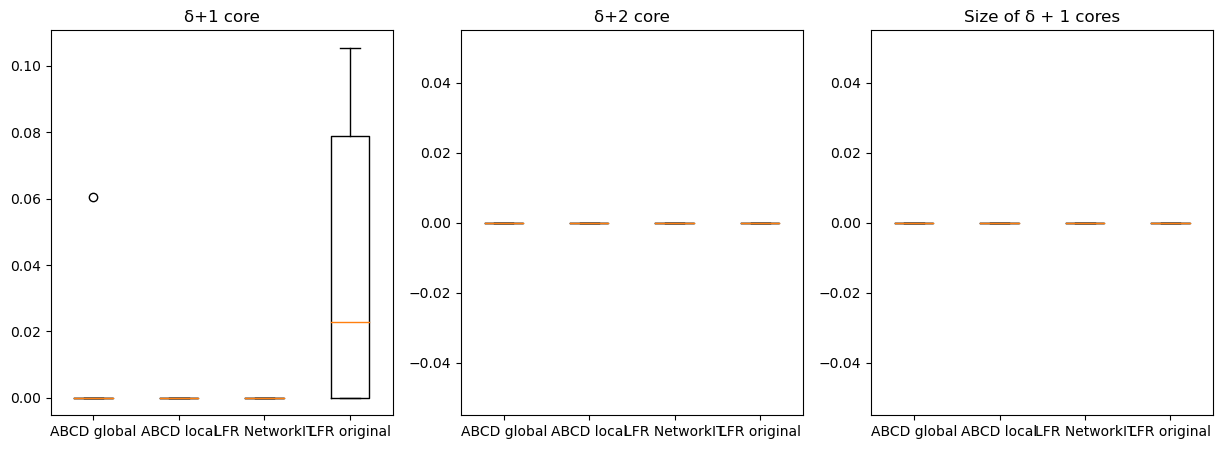

PyObject Text(0.5, 1.0, 'Size of δ + 1 cores')

In [16]:
fig = figure("δ + k cores",figsize = (15,5)) # Create a new blank figure
subplot(131)
attr = Symbol("δ+1")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("δ+1 core") 
subplot(132)
attr = Symbol("δ+2")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("δ+2 core") 
subplot(133)
attr = Symbol("δ+3")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("δ+3 core") 
title("Size of δ + 1 cores")

#saving to a file:
#savefig("fig4.eps")

# Robustness and Giant Component size

Plot show the giant component size and robustness of the graph (size of the giant component after removal of $p$ percent of the nodes with the highest degree, relatively to the size of the original graph)

In [17]:
ps = [0.05, 0.1, 0.15];

In [18]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.9
min_deg = 5
p = 0.1

0.1

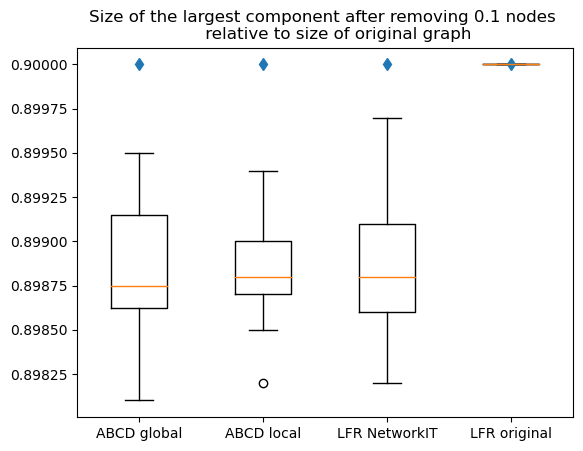

PyObject Text(0.5, 1.0, 'Size of the largest component after removing 0.1 nodes \n     relative to size of original graph')

In [19]:
attr = Symbol("size_$p")
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
plot(1:4, (1.0 - p).* ones(4), "d")
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("Size of the largest component after removing $p nodes 
     relative to size of original graph") 

#saving to a file:
#savefig("fig5.eps")

In [20]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.9
min_deg = 5

5

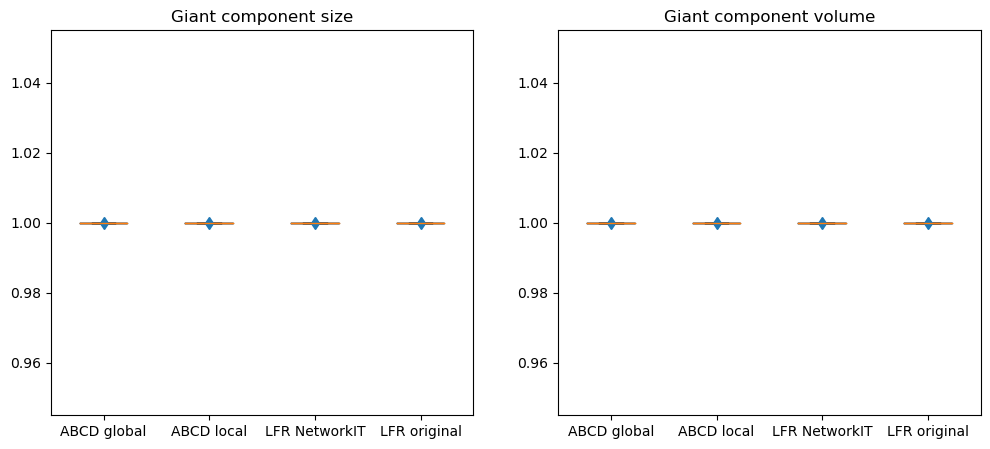

PyObject Text(0.5, 1.0, 'Giant component volume')

In [21]:
ig = figure("Giant component size and volume",figsize = (12,5)) # Create a new blank figure
subplot(121)
attr = :giant_component_size
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
plot(1:4, ones(4), "d")
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("Giant component size") 
subplot(122)
attr = :giant_component_volume
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
plot(1:4, ones(4), "d")
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("Giant component volume") 

#saving to a file:
#savefig("fig6.eps")

# Proportion of Internal Edges

In [22]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.9
min_deg = 5

5

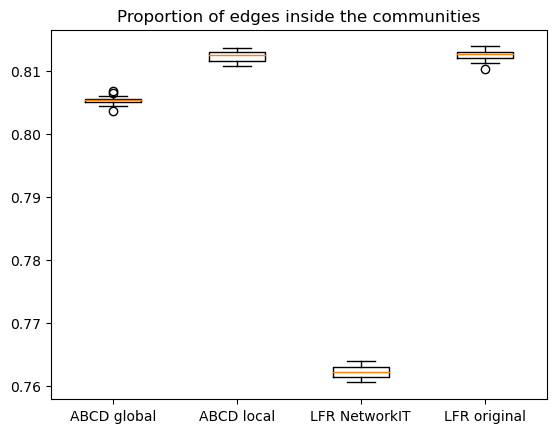

PyObject Text(0.5, 1.0, 'Proportion of edges inside the communities')

In [23]:
attr = :internal_edges_mean
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("Proportion of edges inside the communities") 

#saving to a file:
#savefig("fig7.eps")

# Correlation coefficient and correlation exponent

In [24]:
#Parameters:

ξ = 0.5
β = 1.5
γ = 2.9
min_deg = 5

5

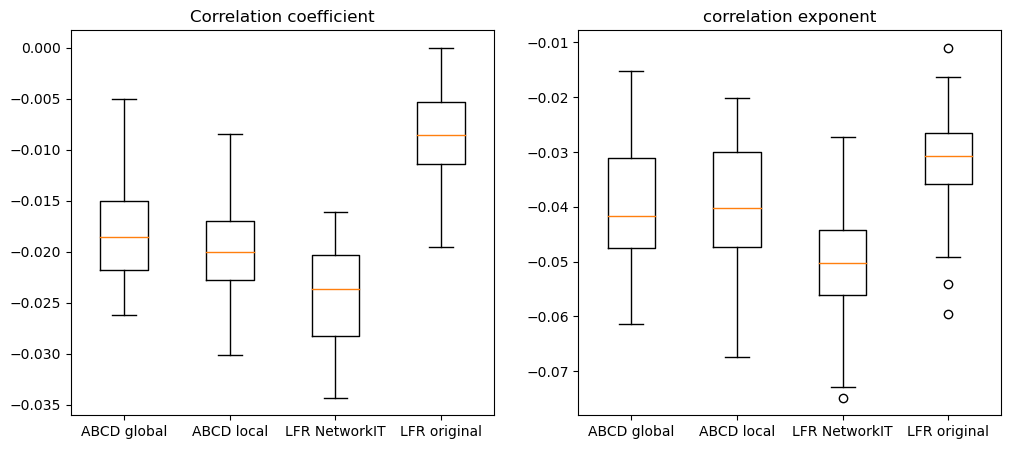

PyObject Text(0.5, 1.0, 'correlation exponent')

In [25]:
ig = figure("Giant component size and volume",figsize = (12,5)) # Create a new blank figure
subplot(121)
attr = :correlation_coeff
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("Correlation coefficient") 
subplot(122)
attr = :corr_exp
data = [get_plot_data("ABCD", "false", attr), get_plot_data("ABCD", "true", attr),
            get_plot_data("LFR", "", attr), get_plot_data("LFRog", "", attr)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
PyPlot.title("correlation exponent") 

#saving to a file:
#savefig("fig8.eps")

# KNN function plots

In [26]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.9
min_deg = 5
λ  = 1000.0

1000.0

### Separate plots

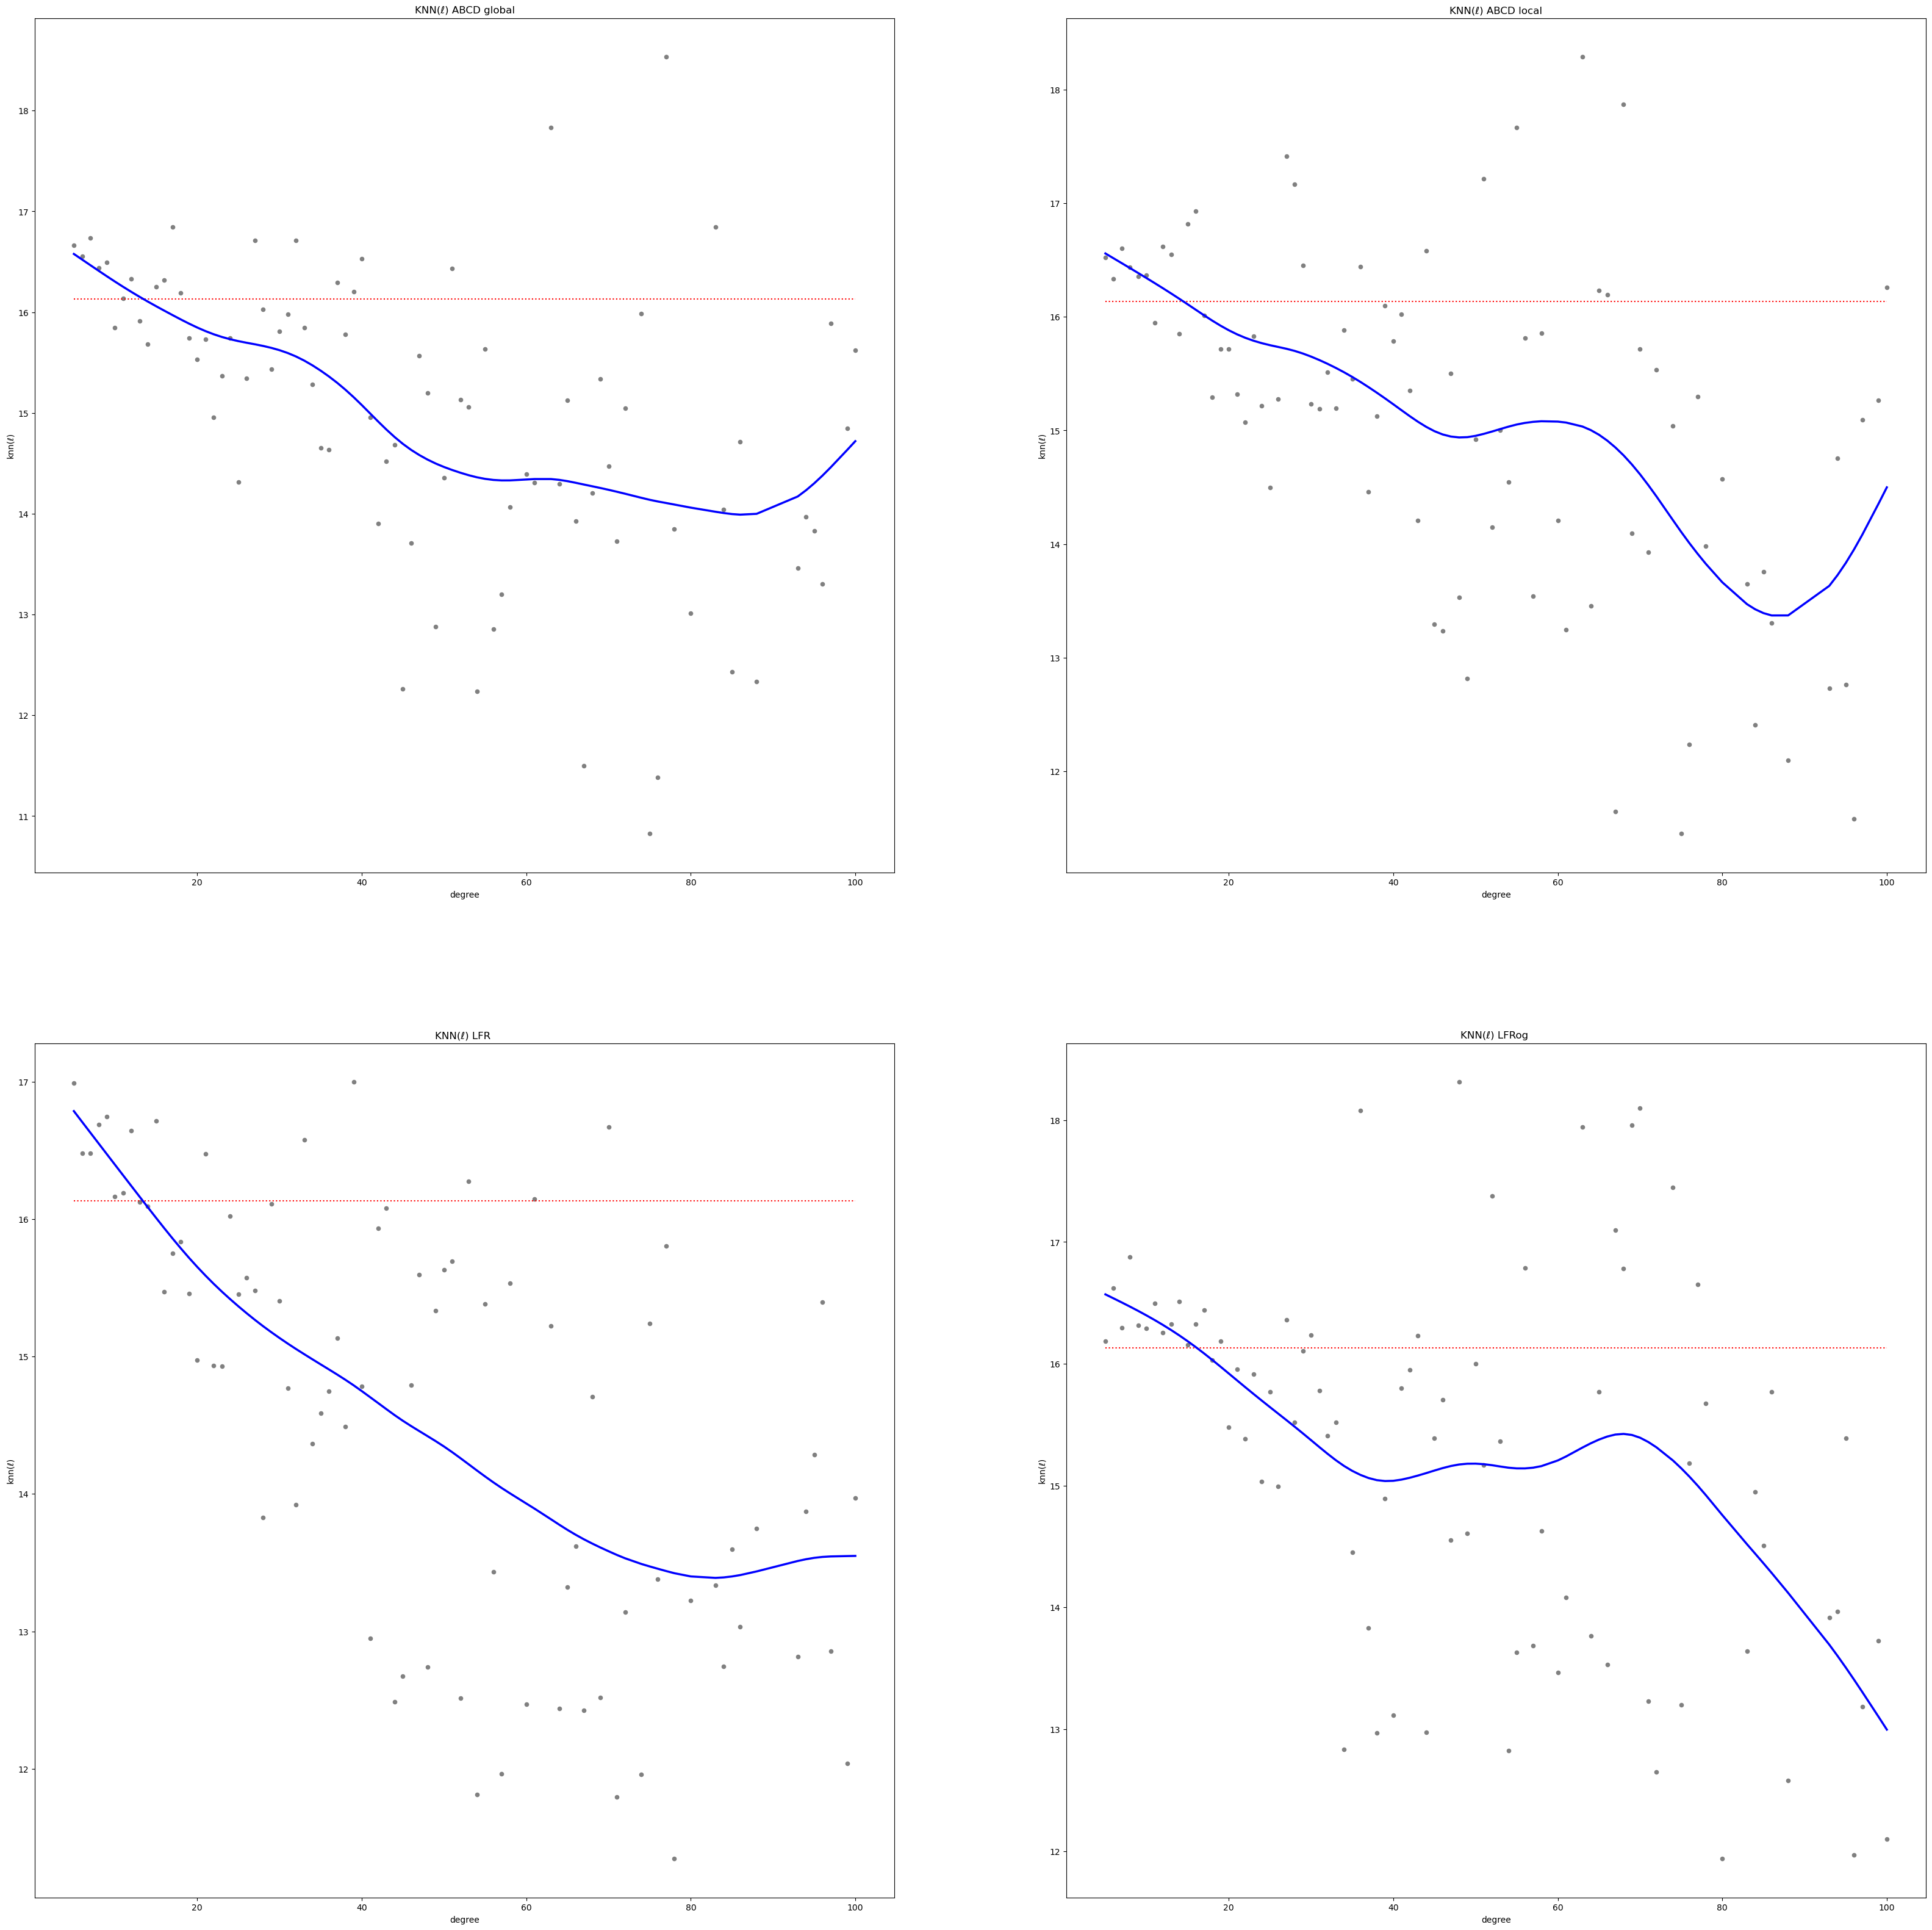

In [27]:
fig = figure("KNN plots",figsize = (40,40))
k = 1
for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFR", ""),("LFRog", "")]
    subplot(parse(Int, "22" * "$k"))
    (typeof(islocal) == Bool) ? (islocal ? algtype = "local" : algtype = "global") : algtype = ""
    algo == "LFRog" ? (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).nse"; start = 2) :
    (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"; start = 1)
    g = SimpleGraphFromIterator([Graphs.SimpleEdge(parse.(Int,e[1]),parse.(Int,e[2])) 
                    for e in split.(readlines(name))[start:end]])
    x = sort(unique(degree(g)))
    y = degree_correlation(g)
    r = deg_corr_neutral(g, degree)
    hlines(y=r,xmin=minimum(x),xmax=maximum(x),linestyles=":", color = "red")
    scatter(x,y, color = "gray", s = 20)
    spl = fit(SmoothingSpline, Float64.(x), y, λ)
    y_pred = predict(spl)
    plot(x, y_pred, "blue", linewidth=2.5)
    xlabel("degree")
    ylabel("knn(ℓ)")
    PyPlot.title("KNN(ℓ) $algo $algtype") 
    k +=1
end

#saving to a file:
#savefig("fig9.eps")

### One plot:

In [28]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.9
min_deg = 5
λ  = 1000.0

1000.0

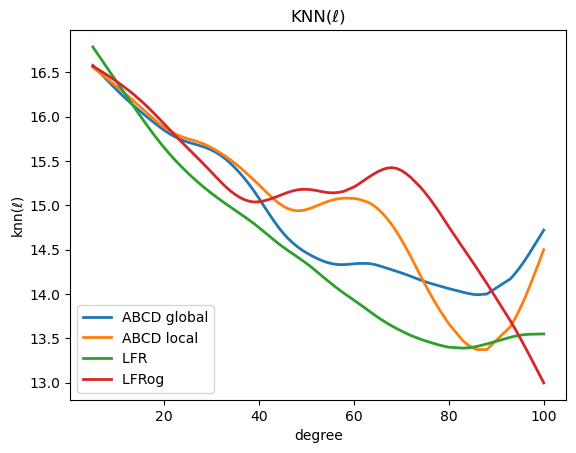

In [29]:
for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFR", ""),("LFRog", "")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "local" : algtype = "global") : algtype = ""
    algo == "LFRog" ? (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).nse"; start = 2) :
    (name = graphdir * "$(algo)_1_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"; start = 1)
    g = SimpleGraphFromIterator([Graphs.SimpleEdge(parse.(Int,e[1]),parse.(Int,e[2])) 
                    for e in split.(readlines(name))[start:end]])
    x = sort(unique(degree(g)))
    y = degree_correlation(g)
    spl = fit(SmoothingSpline, Float64.(x), y, λ)
    y_pred = predict(spl)
    plot(x, y_pred, linewidth=2, label = "$algo $algtype")
    legend(loc="lower left")
    xlabel("degree")
    ylabel("knn(ℓ)")
    PyPlot.title("KNN(ℓ)") 
end

#saving to a file:
#savefig("fig10.eps")

# Shortest path length

In [30]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.9
min_deg = 5

5

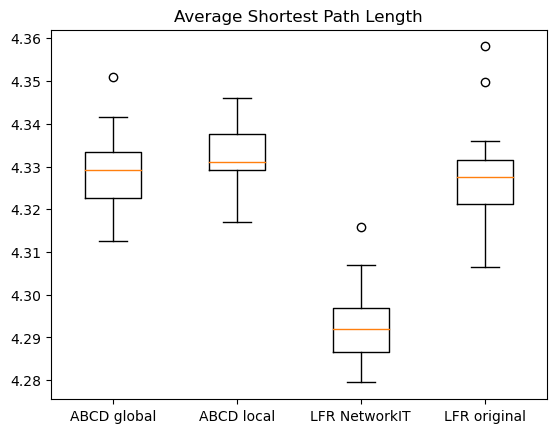

PyObject Text(0.5, 1.0, 'Average Shortest Path Length')

In [31]:
attr = :avg

data = [get_plot_data("ABCD", "false", attr, fname = "paths", colnames = colnames2),
    get_plot_data("ABCD", "true", attr, fname = "paths", colnames = colnames2),
            get_plot_data("LFR", "", attr,  fname = "paths", colnames = colnames2), 
    get_plot_data("LFRog", "", attr,  fname = "paths", colnames = colnames2)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
title("Average Shortest Path Length")

#saving to a file:
#savefig("fig11.eps")

# Centrality measures

In [32]:
centralities = [:betweenness_centrality, :closeness_centrality, :degree_centrality,  :pagerank];

### CDF plots

In [36]:
#Parameters:

ξ = 0.2
β = 1.5
γ = 2.9
min_deg = 5

5

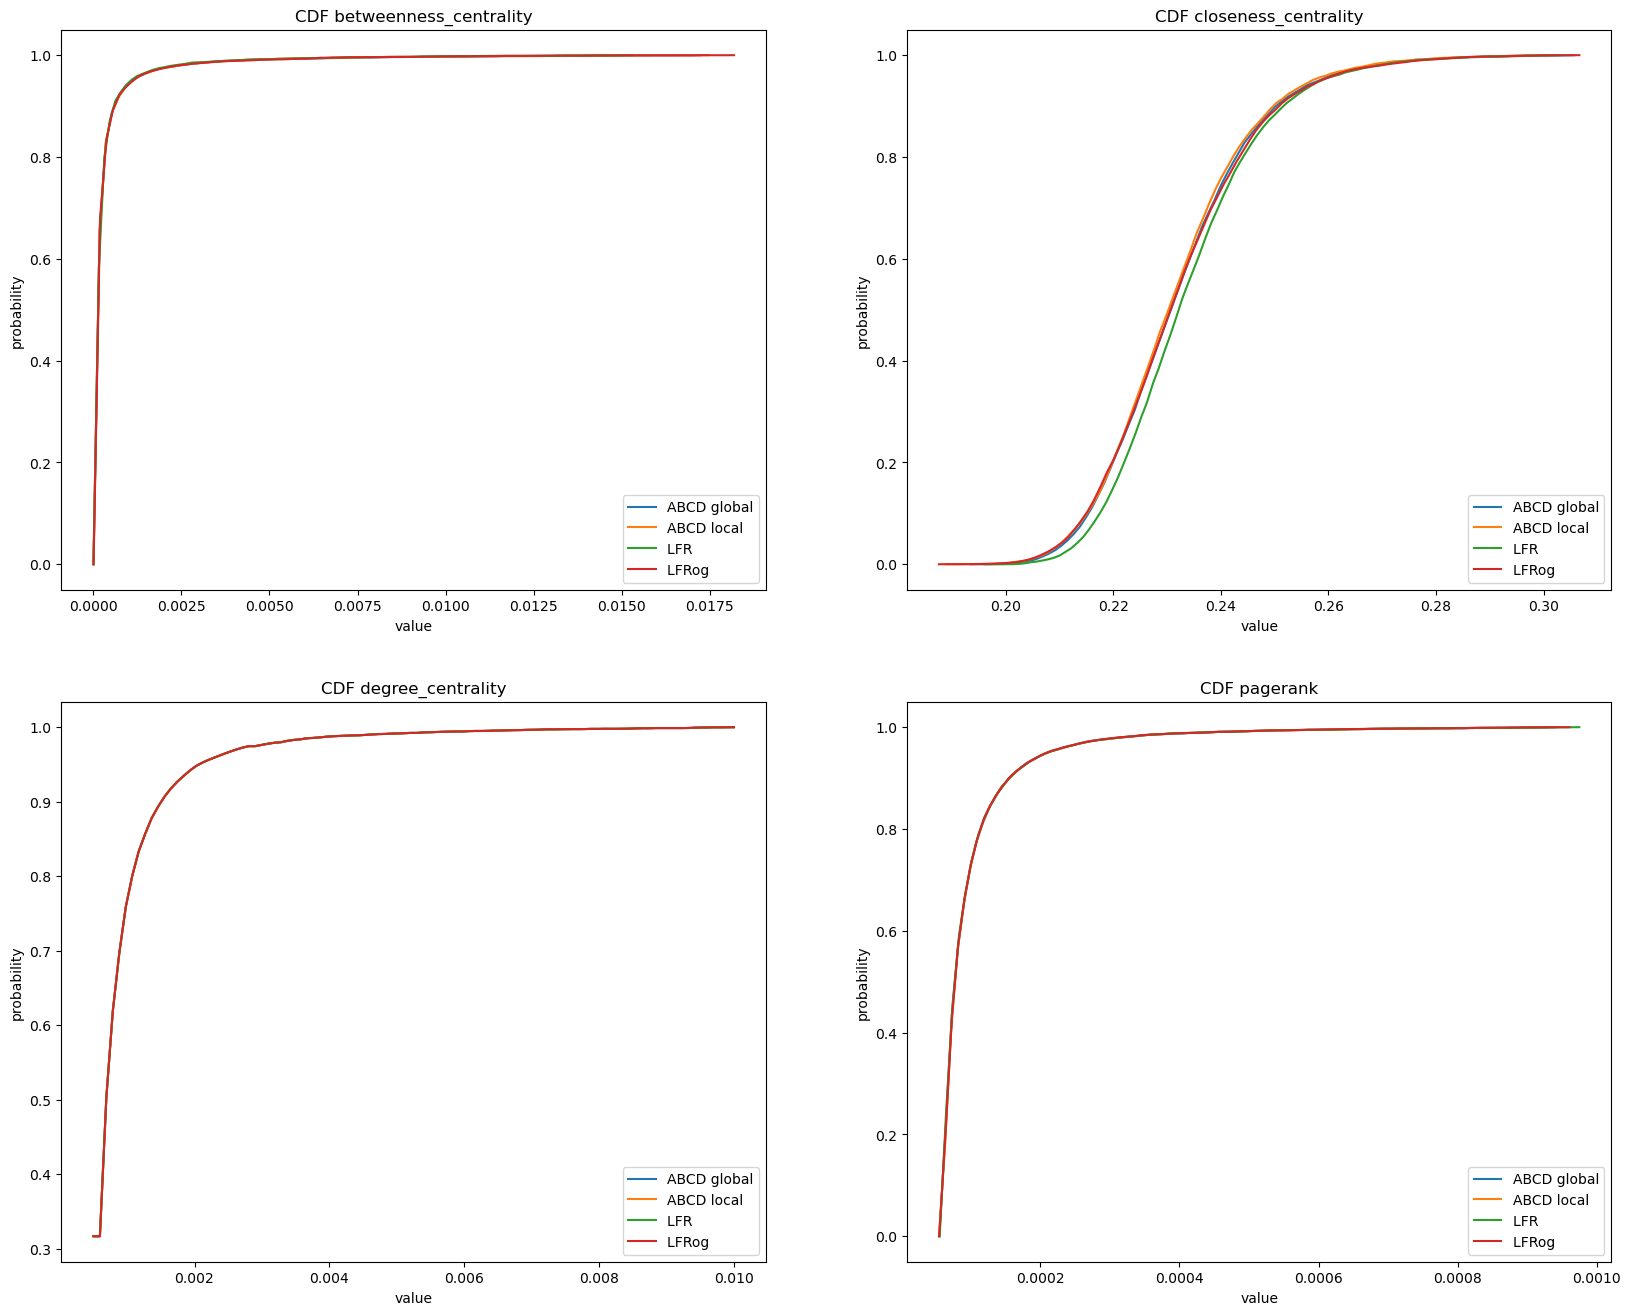

In [37]:
fig = figure("CDF for different centralities",figsize = (20,16))
k = 1
for centrality in Symbol.(centralities)
    subplot(parse(Int, "22" * "$k"))
    for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFR", ""),("LFRog", "")]
        (typeof(islocal) == Bool) ? (islocal ? algtype = "local" : algtype = "global") : algtype = ""
        name = resdir * "$(centrality)/$(algo)_$(centrality)_raw_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"
        data =  parse.(Float64, reduce(hcat, split.(readlines(name), "\t")))
        plot(data[1,:],data[2,:], label = "$algo $algtype")
        legend(loc="lower right")
        xlabel("value")
        ylabel("probability")
        PyPlot.title("CDF $(centrality)") 
    end
    k += 1
end
#saving to a file:
#savefig("fig12.eps")

# Nodes participation stats

### Average participation coefficient

In [81]:
#Parameters:

ξ = 0.8
β = 1.5
γ = 2.9
min_deg = 5

5

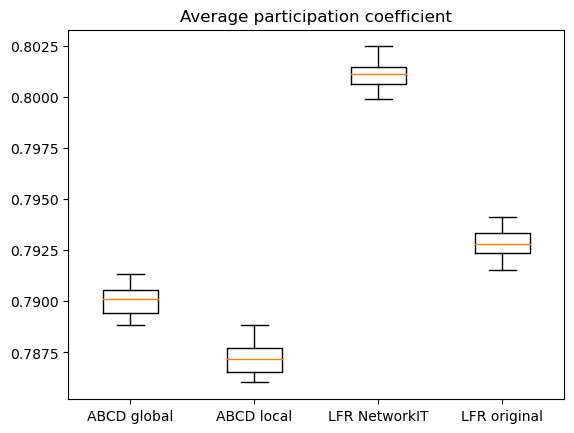

PyObject Text(0.5, 1.0, 'Average participation coefficient')

In [85]:
attr = :avg_part_coeff

data = [get_plot_data("ABCD", "false", attr, fname = "participation", colnames = colnames3),
    get_plot_data("ABCD", "true", attr, fname = "participation", colnames = colnames3),
            get_plot_data("LFR", "", attr,  fname = "participation", colnames = colnames3), 
    get_plot_data("LFRog", "", attr,  fname = "participation", colnames = colnames3)]
minlen = minimum(length.(data))
boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
title("Average participation coefficient")

#saving to a file:
#savefig("fig11.eps")

### Plot

In [263]:
#Parameters:

ξ = 0.7
β = 1.9
γ = 2.9
min_deg = 5

5

In [264]:
dt = DataFrame(colnames3 .=> fill([],length(colnames3)))
rename!(dt, :avg_part_coeff =>:algorithm)
for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFR", ""),("LFRog", "")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "local" : algtype = "global") : algtype = ""
    name = resdir * "$(algo)_participation_$(n)_$(ξ)_$(β)_$(γ)_$(min_deg)_$(islocal).dat"
    df = DataFrame(mean(Array(hcat([parse.(Float64, x) for x in split.(readlines(name),";")]...)'), dims = 1)
    , colnames3)
    select!(df, Not(:avg_part_coeff))
    insertcols!(df, 1, :algorithm => ["$algo $algtype"])
    dt = vcat(dt,df)        
end

In [265]:
dt

,algorithm,hubs,provincial_hubs,connector_hubs,kinless_hubs,ultra_peripheral_nodes
,Any,Any,Any,Any,Any,Any
1,ABCD global,0.02629,0.000123916,0.0774628,0.922413,0.000253333
2,ABCD local,0.0263167,0.0,0.0623438,0.937656,0.00022
3,LFR,0.02653,0.0,0.00100166,0.998998,0.0
4,LFRog,0.0261583,0.0,0.000647447,0.999353,0.0


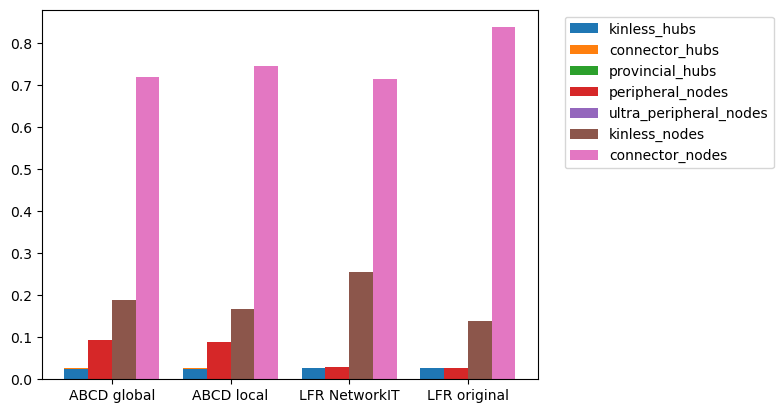

PyObject <matplotlib.legend.Legend object at 0x00000000AF012550>

In [289]:
N = 1:1:4
width = 0.2
logscale = false #scale of the plot

kinless_hubs = dt[!,:hubs] .*  dt[!,:kinless_hubs]
connector_hubs = dt[!,:hubs] .*  dt[!,:connector_hubs]
provincial_hubs = dt[!,:hubs] .*  dt[!,:provincial_hubs]

bar(N .+ 0.00, kinless_hubs, width = width, label = "kinless_hubs")
bar(N .+ 0.00, connector_hubs, width = width, bottom = kinless_hubs, label = "connector_hubs")
bar(N .+ 0.00, provincial_hubs, width = width, bottom = connector_hubs, label = "provincial_hubs")
bar(N .+ 0.20, dt[!,:peripheral_nodes], width = width, label = "peripheral_nodes")
bar(N .+ 0.20, dt[!,:ultra_peripheral_nodes], width = width, label = "ultra_peripheral_nodes",
    bottom = dt[!,:peripheral_nodes])
bar(N .+ 0.40, dt[!,:kinless_nodes], width = width, label = "kinless_nodes")
bar(N .+ 0.60, dt[!,:connector_nodes], width = width, label = "connector_nodes")


logscale && yscale("log")
xticks(N .+ 0.3,["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Boxplots for different values of $\beta$'s and $\gamma$'s

In [55]:
#Parameters:

ξ = 0.8
β = 1.5
γ = 2.9
min_deg = 5
attr = :modularity;
cname, fname = colnames, "stats";

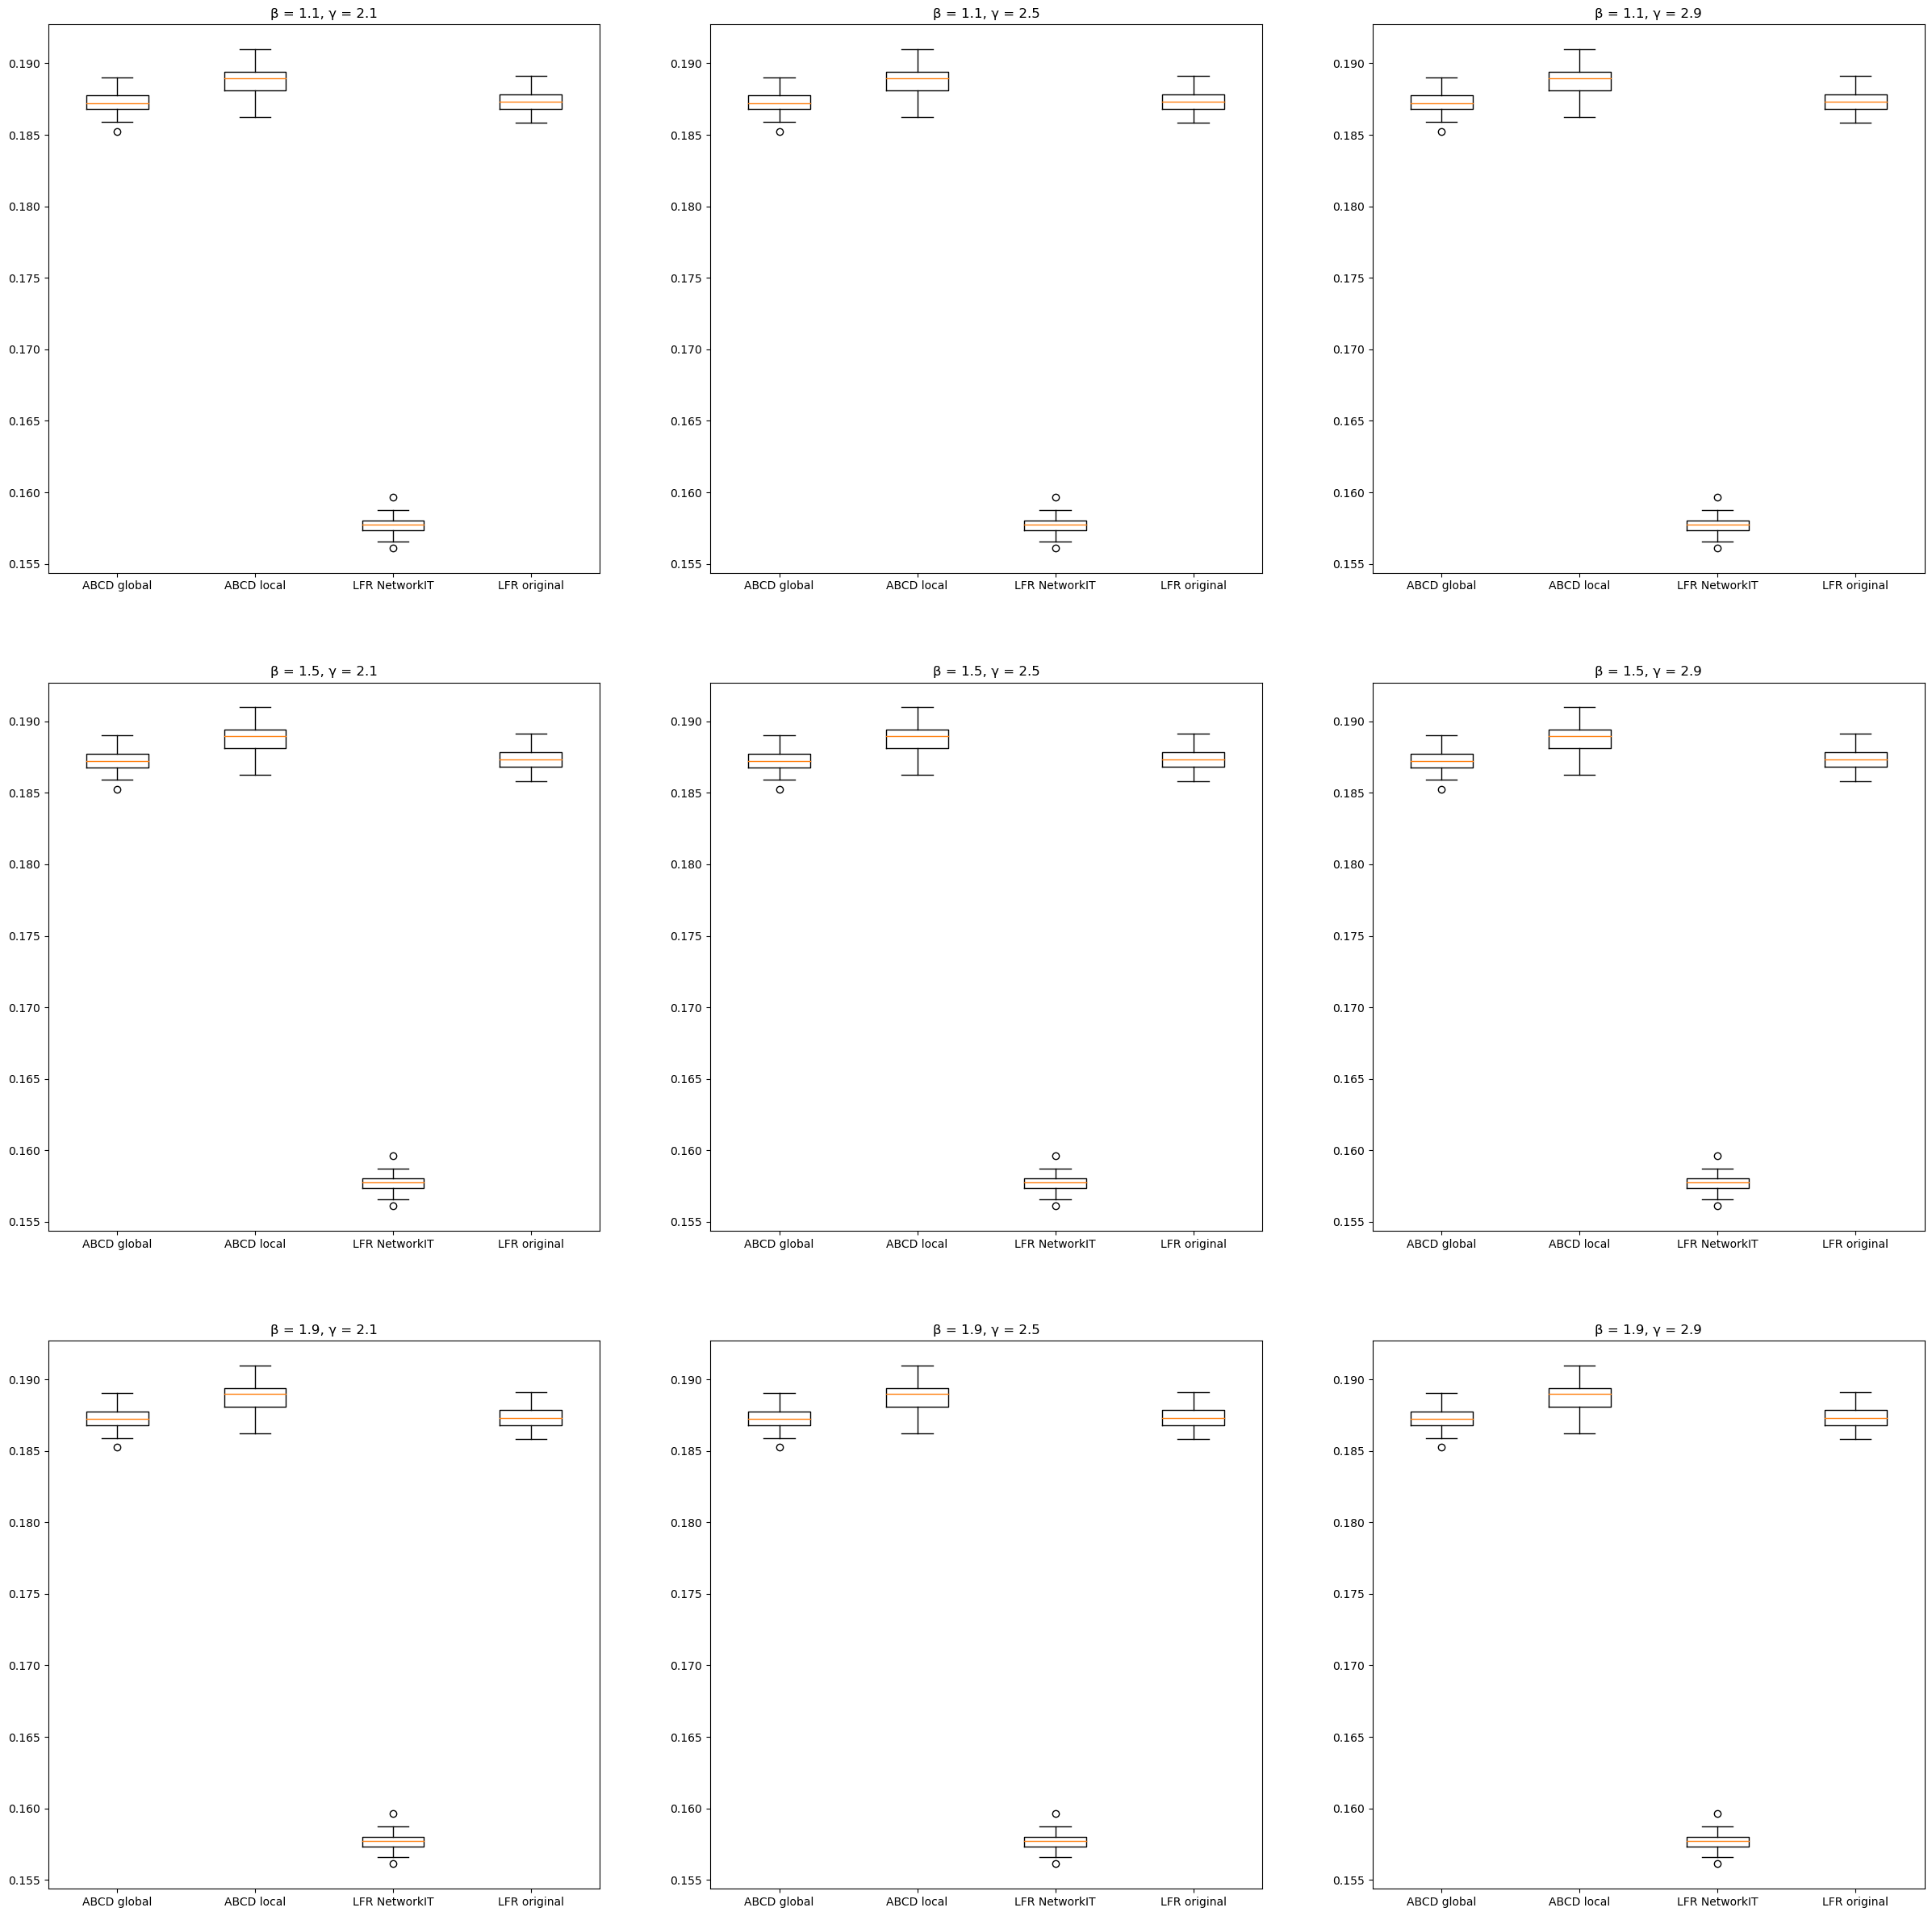

In [56]:
fig = figure("$(attr) for different values of β and γ",figsize = (30,30)) 
k = 1
for (i,β) in enumerate(βs)
    for (j,γ) in enumerate(γs)
        subplot(parse(Int, "33" * "$k"))
        data = [get_plot_data("ABCD", "false", attr, fname = fname, colnames = cname),
            get_plot_data("ABCD", "true", attr, fname = fname, colnames = cname),
            get_plot_data("LFR", "", attr,  fname = fname, colnames = cname), 
            get_plot_data("LFRog", "", attr,  fname = fname, colnames = cname)]
        minlen = minimum(length.(data))
        boxplot(hcat([data[i][1:minlen] for i = 1:length(data)]...))
        xticks([1,2,3,4],["ABCD global", "ABCD local", "LFR NetworkIT", "LFR original"])
        PyPlot.title("β = $β, γ = $γ") 
        k += 1
    end
end

#saving to a file:
#savefig("fig.eps")

# Plot for different $\xi$'s

### Separate plots

In [64]:
#Parameters:

ξ = 0.8
β = 1.5
γ = 2.9
min_deg = 5
attr = :global_coeff
α = 0.05

0.05

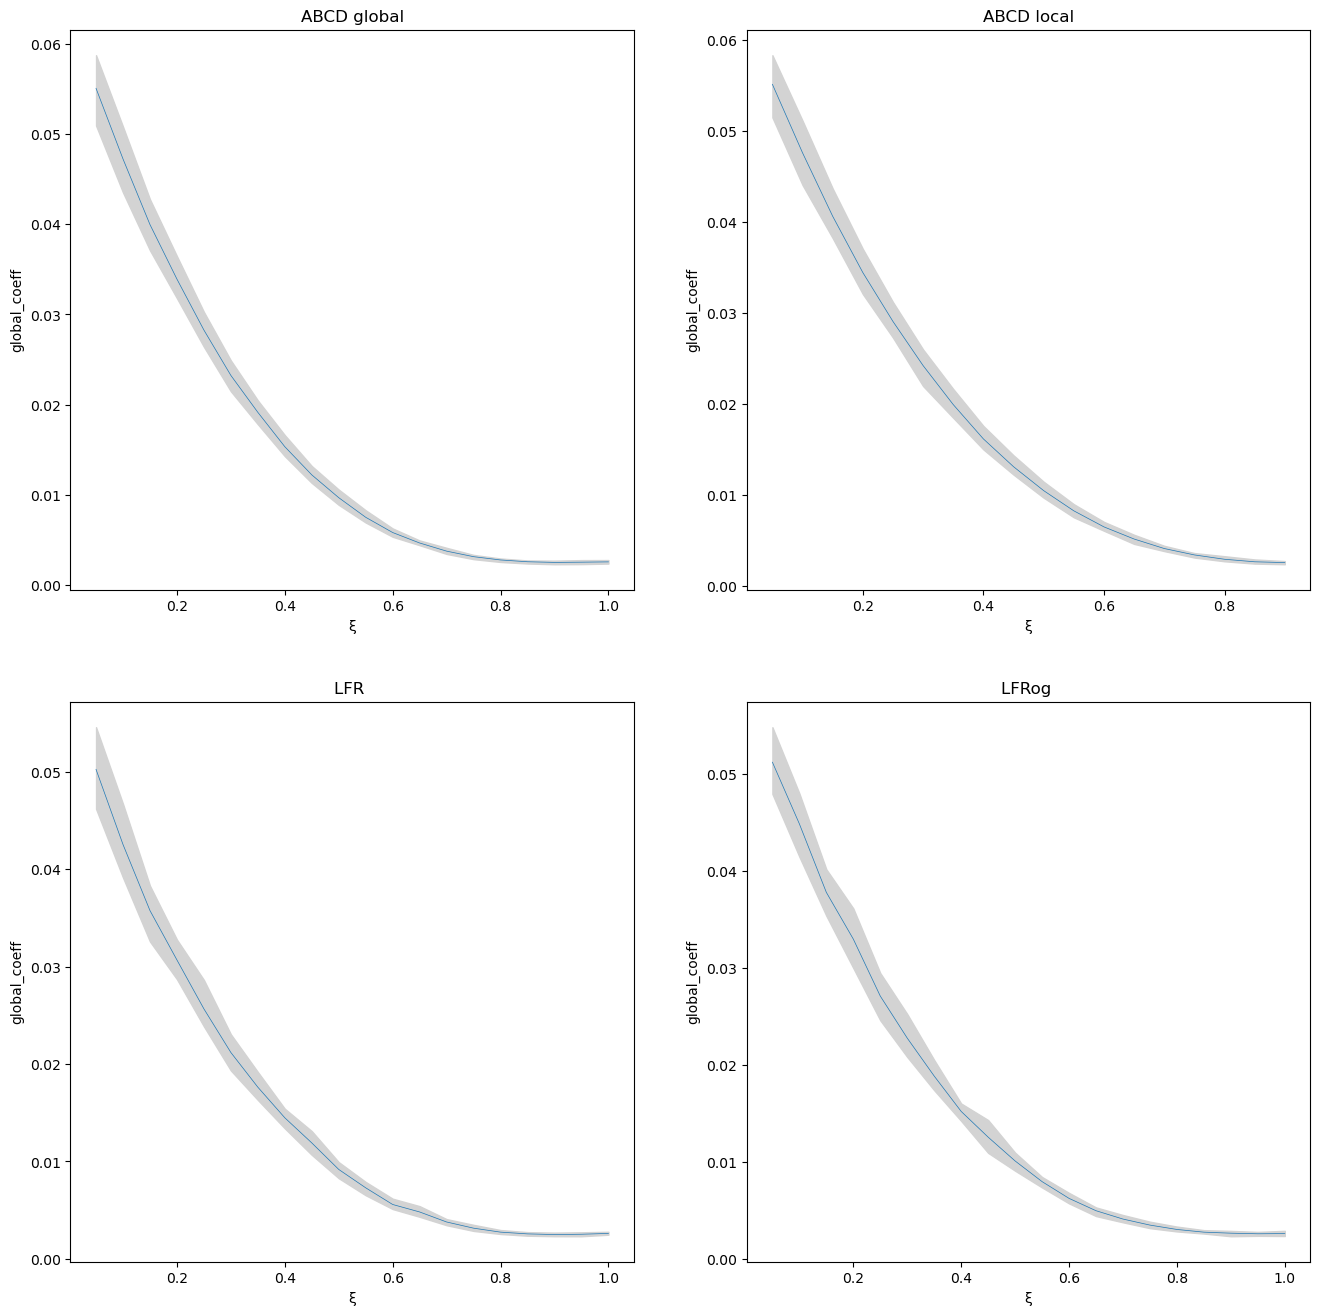

In [65]:
fig = figure("$(attr) ξ plot", figsize = (16,16))
k = 1
for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFR", ""),("LFRog", "")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "local" : algtype = "global") : algtype = ""
    subplot(parse(Int, "22" * "$k"))
    vals = zeros(length(ξs),3)
    for (i, xi) in enumerate(ξs)
        ξs == 0 && continue
        try
            data = get_plot_data(algo, islocal, attr, ξ = xi)
            vals[i,:] = [mean(data), quantile(data, α/2), 
                        quantile(data,1 - α/2)]
        catch
            vals[i,:] = [NaN,NaN,NaN]
        end
    end
    plot(ξs[2:end],vals[2:end,1], linewidth=0.5)
    fill_between(ξs[2:end],vals[2:end,2],vals[2:end,3], color = "lightgray")
    xlabel("ξ")
    ylabel("$(attr)")
    PyPlot.title("$(algo) $algtype") 
    k += 1
end

#saving to a file:
#savefig("fig.eps")

### Joint plot

In [79]:
#Parameters:

ξ = 0.8
β = 1.5
γ = 2.9
min_deg = 5
attr = :global_coeff
α = 0.05
ribbon = true #true if ribbon - in the most cases it is unreadable

true

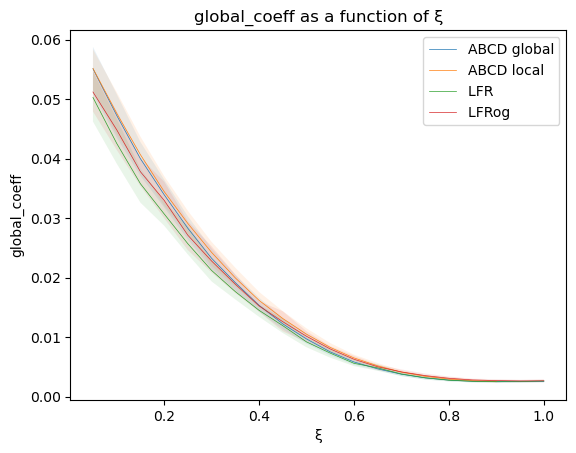

PyObject Text(0.5, 1.0, 'global_coeff as a function of ξ')

In [80]:
for (algo, islocal) in [("ABCD", false),("ABCD", true),("LFR", ""),("LFRog", "")]
    (typeof(islocal) == Bool) ? (islocal ? algtype = "local" : algtype = "global") : algtype = ""
    vals = zeros(length(ξs),3)
    for (i, xi) in enumerate(ξs)
        ξs == 0 && continue
        try
            data = get_plot_data(algo, islocal, attr, ξ = xi)
            vals[i,:] = [mean(data), quantile(data, α/2), 
                        quantile(data,1 - α/2)]
        catch
            vals[i,:] = [NaN,NaN,NaN]
        end
    end
    plot(ξs[2:end],vals[2:end,1], linewidth=0.5, label = "$algo $algtype")
    ribbon && fill_between(ξs[2:end],vals[2:end,2],vals[2:end,3], alpha = 0.1)
    xlabel("ξ")
    ylabel("$(attr)")
     
end
legend(loc = "upper right")
PyPlot.title("$attr as a function of ξ")

#saving to a file:
#savefig("fig.eps")